In [76]:
import pickle
import time
import re
import glob
import os
import shutil
import numpy as np
from matplotlib import pyplot
import tensorflow as tf
from nltk.corpus import stopwords
import random
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import gensim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Activation, Reshape
from keras.layers import Convolution1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

In [118]:
def remove_stopwords(article):
    stopword_list = set(stopwords.words("english"))
    return [word for word in article.split() if word not in stopword_list]


def remove_character(article):
    return re.sub("[^a-zA-Z]+", " ", article)

def remove_one_character_token(article) : 
    return [word for word in article if len(word)>1]
    
def lower(string):
    return string.lower()


def clean(article):
    article = article.strip()
    article = lower(article)
    article = remove_character(article)
    article = remove_stopwords(article)
    article = remove_one_character_token(article)
    article = ' '.join(article)
    return article

def clean2(article):
    #article = article.strip()
    article = lower(article)
    article = remove_character(article)
    article = remove_stopwords(article)
    article = remove_one_character_token(article)
    article = ' '.join(article)
    return article

In [130]:
def create_input_count_vec(max_n_word=20000,mode_tfidf = True) : 
    
    text_train = []
    target_train = []
    text_val = []
    target_val = []
    text_test = []
    target_test = []   
    
    print('Loading and cleaning files ...')
    
    t0 = time.time()

    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/train_list/*.txt') : 
        file = open(link,'r')
        text_train.append(clean(file.read()))
        target_train.append(int(os.path.basename(file.name)[0:2]))

        
    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/val_list/*.txt') : 
        file = open(link,'r')
        text_val.append(clean(file.read()))
        target_val.append(int(os.path.basename(file.name)[0:2]))   

    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/test_list/*.txt') : 
        file = open(link,'r')
        text_test.append(clean(file.read()))
        target_test.append(int(os.path.basename(file.name)[0:2]))   
        
    t1 = time.time()
    
    print('Loading and cleaning files time : ','%.1f' % (t1-t0),'s')
    
    print('Count Vectorization ...')
    
    if mode_tfidf == True : 
        vectorizer = TfidfVectorizer(max_features = max_n_word)
        print('mode : tdidf')
    else : 
        vectorizer = CountVectorizer(max_features = max_n_word)
        print('mode : simple count')
        
    x_train = vectorizer.fit_transform(text_train)
    y_train = np.asarray(target_train)
  
    x_val = vectorizer.transform(text_val)
    y_val = np.asarray(target_val)
    
    x_test = vectorizer.transform(text_test)
    y_test = np.asarray(target_test)
    
    t2 = time.time()
    print('Vectorization time : ', '%.1f' % (t2-t1),'s')
    
    return x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test

In [132]:
def create_sentences_input() : 
    t0 = time.time()
    print('Creating tokenized sentences to feed Word2Vec model ...')
    list_of_sentences = []
    cnt = 0
    for link in glob.glob('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/train_list/*.txt') : 
        file = open(link,'r')
        article = file.read()
        split_art= re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s',article) #split into sentences
        for sentence in split_art :
            clean_sentence = clean2(sentence)
            sentence_into_list = clean_sentence.split() 
            list_of_sentences.append(sentence_into_list)
        #cnt+=1
        #if cnt>10 : 
        #    break
    t1 = time.time()
    print('Splitting and cleaning time : ', '%.1f' % (t1-t0),'s')
    return list_of_sentences

In [74]:
x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = create_input_count_vec(max_n_word=20000,mode_tfidf = False)
#sets = x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test
sets2 = x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test

Loading and cleaning files ...
Loading and cleaning files time :  46.62173414230347
Count Vectorization ...
mode : simple count
Vectorization time :  27.406813859939575


In [133]:
list_sentences_train = create_sentences_input()

Creating tokenized sentences to feed Word2Vec model ...
Splitting and cleaning time :  336.3 s


In [121]:
print(list_sentences_train)

[['knight', 'tour', 'sequence', 'moves', 'knight', 'chessboard', 'knight', 'visits', 'every', 'square', 'exactly'], ['knight', 'ends', 'square', 'one', 'knight', 'move', 'beginning', 'square', 'could', 'tour', 'board', 'immediately', 'following', 'path', 'tour', 'closed', 'otherwise', 'open', 'knight', 'tour', 'problem', 'mathematical', 'problem', 'finding', 'knight', 'tour'], ['creating', 'program', 'find', 'knight', 'tour', 'common', 'problem', 'given', 'computer', 'science', 'students'], ['variations', 'knight', 'tour', 'problem', 'involve', 'chessboards', 'different', 'sizes', 'usual', 'well', 'irregular', 'non', 'rectangular', 'boards'], ['theory', 'knight', 'tour', 'problem', 'instance', 'general', 'hamiltonian', 'path', 'problem', 'graph', 'theory'], ['problem', 'finding', 'closed', 'knight', 'tour', 'similarly', 'instance', 'hamiltonian', 'cycle', 'problem'], ['unlike', 'general', 'hamiltonian', 'path', 'problem', 'knight', 'tour', 'problem', 'solved', 'linear', 'time'], ['hist

NameError: name 'split' is not defined

### ML models

In [6]:
def run_logreg(sets) :
    x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = sets
    print('Build logistic regression model ...')
    clf = LogisticRegression(random_state=0)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    acc = accuracy_score(y_train, y_pred)
    y_pred = clf.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)
    
    print('acc :', acc)
    print('val acc :', val_acc)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    return #clf.predict_proba(np.concatenate((x_train, x_val), axis=0))[:, 1], \
           #clf.predict_proba(x_test)[:, 1], \
           #np.concatenate((y_train, y_val), axis=0)

#### With tfidf

In [7]:
run_logreg(sets)

Build logistic regression model ...
acc : 0.9295279912184413
val acc : 0.857703081232493
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       400
           1       0.88      0.92      0.90       400
           2       0.88      0.79      0.83       185
           3       0.82      0.86      0.84       400
           4       0.79      0.79      0.79       400

    accuracy                           0.86      1785
   macro avg       0.86      0.85      0.85      1785
weighted avg       0.86      0.86      0.86      1785

[[359   4   0  19  18]
 [  3 369   1   9  18]
 [  1   2 146  20  16]
 [  7   4  12 343  34]
 [ 13  40   7  26 314]]


/Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Simple count

In [75]:
run_logreg(sets2)

Build logistic regression model ...
acc : 0.9670691547749726
val acc : 0.8140056022408964
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       400
           1       0.84      0.87      0.86       400
           2       0.70      0.75      0.72       185
           3       0.79      0.81      0.80       400
           4       0.76      0.70      0.73       400

    accuracy                           0.81      1785
   macro avg       0.80      0.81      0.80      1785
weighted avg       0.81      0.81      0.81      1785

[[361   5   3  16  15]
 [  3 348   7  11  31]
 [  0   8 138  19  20]
 [ 15   8  32 324  21]
 [ 19  44  16  39 282]]


/Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
def run_svm(sets): 
    x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = sets
    print('Build SVM model ...')
    #[x_train, y_train, x_val, y_val, x_test, y_test] = pickle.load(open('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/dumps/'+str(num_set)+'.dat', "rb"))
    svm = LinearSVC(C=0.0001)
    svm = CalibratedClassifierCV(svm)
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_train)
    acc = accuracy_score(y_train, y_pred)
    y_pred = svm.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)

    print('acc :', acc)
    print('val acc :', val_acc)
    print(y_pred)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    return #svm.predict_proba(np.concatenate((x_train, x_val), axis=0))[:, 1], \
           #svm.predict_proba(x_test)[:, 1], \
           #np.concatenate((y_train, y_val), axis=0)

In [44]:
run_svm(sets)

Build SVM model ...
acc : 0.8384193194291987
val acc : 0.8212885154061624
[4 4 4 ... 3 3 3]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       400
           1       0.84      0.91      0.87       400
           2       0.82      0.77      0.79       185
           3       0.81      0.80      0.80       400
           4       0.71      0.77      0.74       400

    accuracy                           0.82      1785
   macro avg       0.83      0.82      0.82      1785
weighted avg       0.83      0.82      0.82      1785

[[334   5   1  28  32]
 [  3 362   2   9  24]
 [  1   3 142  20  19]
 [  4   8  19 321  48]
 [ 13  51   9  20 307]]


In [10]:
def run_RandomForest(sets):
    x_train, y_train, x_val, y_val, x_test, y_test, text_train, text_val, text_test = sets
    print('Build Random Forest model ...')
    #[x_train, y_train, x_val, y_val, x_test, y_test] = pickle.load(open('/Users/andrealequin/Desktop/Stage_NLP/Simple_extraction/dumps/'+str(num_set)+'.dat', "rb"))
    clf = RandomForestClassifier(max_depth=3, random_state=0)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    acc = accuracy_score(y_train, y_pred)
    y_pred = clf.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)
    
    print('acc :', acc)
    print('val acc :', val_acc)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    return #clf.predict_proba(np.concatenate((x_train, x_val), axis=0))[:, 1], \
           #clf.predict_proba(x_test)[:, 1], \
           #np.concatenate((y_train, y_val), axis=0) 

In [11]:
run_RandomForest(sets)

Build Random Forest model ...
acc : 0.7054884742041713
val acc : 0.6868347338935574
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       400
           1       0.75      0.89      0.82       400
           2       1.00      0.01      0.01       185
           3       0.55      0.80      0.65       400
           4       0.61      0.51      0.56       400

    accuracy                           0.69      1785
   macro avg       0.76      0.61      0.58      1785
weighted avg       0.73      0.69      0.65      1785

[[345  10   0  29  16]
 [  3 355   0  30  12]
 [  4   5   1 116  59]
 [ 21  14   0 320  45]
 [ 24  87   0  84 205]]


## RNN

#### Text to sequences Train/Val/Test

In [68]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower= True)
#tokenizer.fit_on_texts(text_train+text_val+text_test)
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 254729 unique tokens.


In [14]:
X_train = tokenizer.texts_to_sequences(text_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tokenizer.texts_to_sequences(text_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tokenizer.texts_to_sequences(text_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [15]:
Y_train = pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values
Y_test = pd.get_dummies(y_test).values

In [16]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(9110, 250) (9110, 5)
(1785, 250) (1785, 5)
(1785, 250) (1785, 5)


In [17]:
print(Y_train[:10])
print(X_train[:10])

[[0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]]
[[  266    35 19509 ...  1952 16812   627]
 [ 1407   198  3337 ...  3976    20  1474]
 [ 5768 11678  2751 ...  4485  2822   272]
 ...
 [ 4764 47264   304 ...  4689   592   183]
 [    0     0     0 ...   281  2659   376]
 [  582  1525 17734 ...   235   668   244]]


### Keras embeddings

### Model 1

In [19]:
model = Sequential()
model.name="Model 1"
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
#model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(LSTM(50))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 5,030,455
Trainable params: 5,030,455
Non-trainable params: 0
_________________________________________________________________
None


### Model 2

In [23]:
model = Sequential()
model.name="Model 2"
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "Model 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


### Model 3

In [38]:
model = Sequential()
model.name="Model 3"
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "Model 3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 250, 20)           8880      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 105       
_________________________________________________________________
activation_6 (Activation)    (None, 5)                 0         
Total params: 5,011,465
Trainable params: 5,011,465
Non-trainable params: 0
_________________________________________________________________
None


### Model 4

In [72]:
model = Sequential()
model.name="Model 4"
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
#model.add(Dense(64))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "Model 4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
dense_31 (Dense)             (None, 250, 64)           6464      
_________________________________________________________________
flatten_8 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 80005     
_________________________________________________________________
activation_8 (Activation)    (None, 5)                 0         
Total params: 5,086,469
Trainable params: 5,086,469
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#mettre un predict
#verifier meme taille que les batch + positif entre 01

### Model 5

In [64]:
model = Sequential()
model.name="Model 5"
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(Convolution1D(filters=55, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
#opt = tf.keras.optimizers.SGD(learning_rate=0.1)
opt = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "Model 5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 250, 50)           2500000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 250, 55)           2805      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 125, 55)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6875)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 250)               1719000   
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 1255      
Total params: 4,223,060
Trainable params: 4,223,060
Non-trainable params: 0
_________________________________________________

### Word2vec embeddings

In [82]:
from gensim.models import Word2Vec

#### Training Word2vec on the train corpus

In [87]:
len(text_train)

9110

In [ ]:
t0 = time.time()
print('Building Word2Vec Model ...')
model = Word2Vec(list_sentences_train, min_count=5,workers=50)
t1 = time.time()
print('Time for building Word2Vec model : ', '%.1f' % (t1-t0),'s')
print(model)
words = list(model.wv.vocab)
#print(words)
print(model['computer'])
model.save('model.bin')
#new_model = Word2Vec.load('model.bin')
#print(new_model)

Building Word2Vec Model ...


/Users/andrealequin/anaconda/envs/envtf/lib/python3.7/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


#### Using Google Word2vec embedding

In [ ]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

#### Using Stanford Glove embedding

### Training

In [73]:
epochs = 8
batch_size = 256
print(model.name)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val, Y_val))#,callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001)])

Model 4
Train on 9110 samples, validate on 1785 samples
Epoch 1/8
9110/9110 [==============================] - 6s 661us/step - loss: 1.4519 - accuracy: 0.3969 - val_loss: 1.0698 - val_accuracy: 0.6022
Epoch 2/8
9110/9110 [==============================] - 6s 614us/step - loss: 0.7015 - accuracy: 0.7610 - val_loss: 0.6726 - val_accuracy: 0.7922
Epoch 3/8
9110/9110 [==============================] - 5s 598us/step - loss: 0.2892 - accuracy: 0.9154 - val_loss: 0.6103 - val_accuracy: 0.8112
Epoch 4/8
9110/9110 [==============================] - 6s 609us/step - loss: 0.1472 - accuracy: 0.9544 - val_loss: 0.6613 - val_accuracy: 0.8129
Epoch 5/8
9110/9110 [==============================] - 6s 609us/step - loss: 0.0999 - accuracy: 0.9654 - val_loss: 0.7345 - val_accuracy: 0.8067
Epoch 6/8
9110/9110 [==============================] - 6s 615us/step - loss: 0.0939 - accuracy: 0.9671 - val_loss: 0.7324 - val_accuracy: 0.8157
Epoch 7/8
9110/9110 [==============================] - 6s 628us/step - los

In [33]:
print(Y_test[:10])
predi = model.predict(X_test[:10])
print(predi)

[[0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]
[[1.3528421e-03 1.6186993e-03 2.9330724e-03 9.8596579e-01 8.1295492e-03]
 [6.4366329e-03 7.4076112e-03 3.0724794e-02 6.0917634e-01 3.4625465e-01]
 [9.9642700e-01 7.4894115e-04 1.7196660e-04 2.3224107e-03 3.2957166e-04]
 [9.9900609e-01 1.2309388e-04 1.5877011e-04 5.8633450e-04 1.2579457e-04]
 [3.6167121e-04 5.9294113e-04 7.2164985e-05 9.9885881e-01 1.1438524e-04]
 [3.4427838e-03 7.4790544e-03 1.1190693e-01 1.3553496e-02 8.6361778e-01]
 [1.1727656e-03 3.0610533e-04 9.9129301e-01 5.3895530e-03 1.8385195e-03]
 [2.3449161e-03 9.6384054e-01 2.2051315e-04 2.7292161e-03 3.0864786e-02]
 [1.0065999e-03 9.8953307e-01 7.6744836e-05 7.9820881e-04 8.5853152e-03]
 [9.7230133e-03 2.3949926e-03 9.4043946e-01 1.8279720e-02 2.9162794e-02]]


In [50]:
#Confusion matrix
Y_pred = model.predict(X_test)
y_pred_test = np.argmax(Y_pred, axis=1)
print(y_pred)
Y_test_int = np.argmax(Y_test, axis=1)
print(Y_test_int)
print(confusion_matrix(Y_test_int, y_pred_test))

[4 4 1 ... 3 3 3]
[4 4 4 ... 3 3 3]
[[338   8   1  39  14]
 [  8 346   2   7  37]
 [  3   7 108  42  25]
 [ 17   6  26 312  39]
 [ 13  48  21  52 266]]


In [58]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

911/911 [==============================] - 2s 2ms/step
Test set
  Loss: 2.092
  Accuracy: 0.215


In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

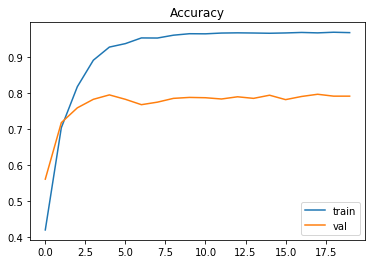

In [36]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show();